In [46]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from scipy.stats import mode

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

# Preprocessing

In [3]:
df.shape

(767, 9)

In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

as we can see there are no empty cells in the dataset

since we are dealing with healthcare dataset, it's important to treat every feature carefully.  
What I mean by that is that it's impossible for someone to have 0 insulin for example. 

In [5]:
# invalid values treatment 
cols_with_potential_invalid = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_potential_invalid] = df[cols_with_potential_invalid].replace(0, np.nan)
df[cols_with_potential_invalid] = df[cols_with_potential_invalid].fillna(df[cols_with_potential_invalid].median())

In [6]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   767.000000  767.000000     767.000000     767.000000  767.000000   
mean      3.848761  121.693611      72.389831      29.105606  140.692308   
std       3.370207   30.440521      12.104228       8.796692   86.437570   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000  100.000000      64.000000      25.000000  121.000000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  140.500000      80.000000      32.000000  127.500000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  767.000000                767.000000  767.000000  767.000000  
mean    32.457888                  0.472081   33.254237    0.349413  
std      6.879262                  0.331496   11.762079    0.477096  
min     18.200000                  0.078000   21.000000    0.000000  
25%     27.500000                  0.243500   24.000000    0.000000  
50%     32.300000                  0.374000   29.000000    0.000000  
75%     36.600000                  0.626500   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [7]:
# defining x-variables and target - y varibale
x = df.drop("Outcome", axis=1)
y = df[["Outcome"]]

In [8]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

### let's check how our features distributed

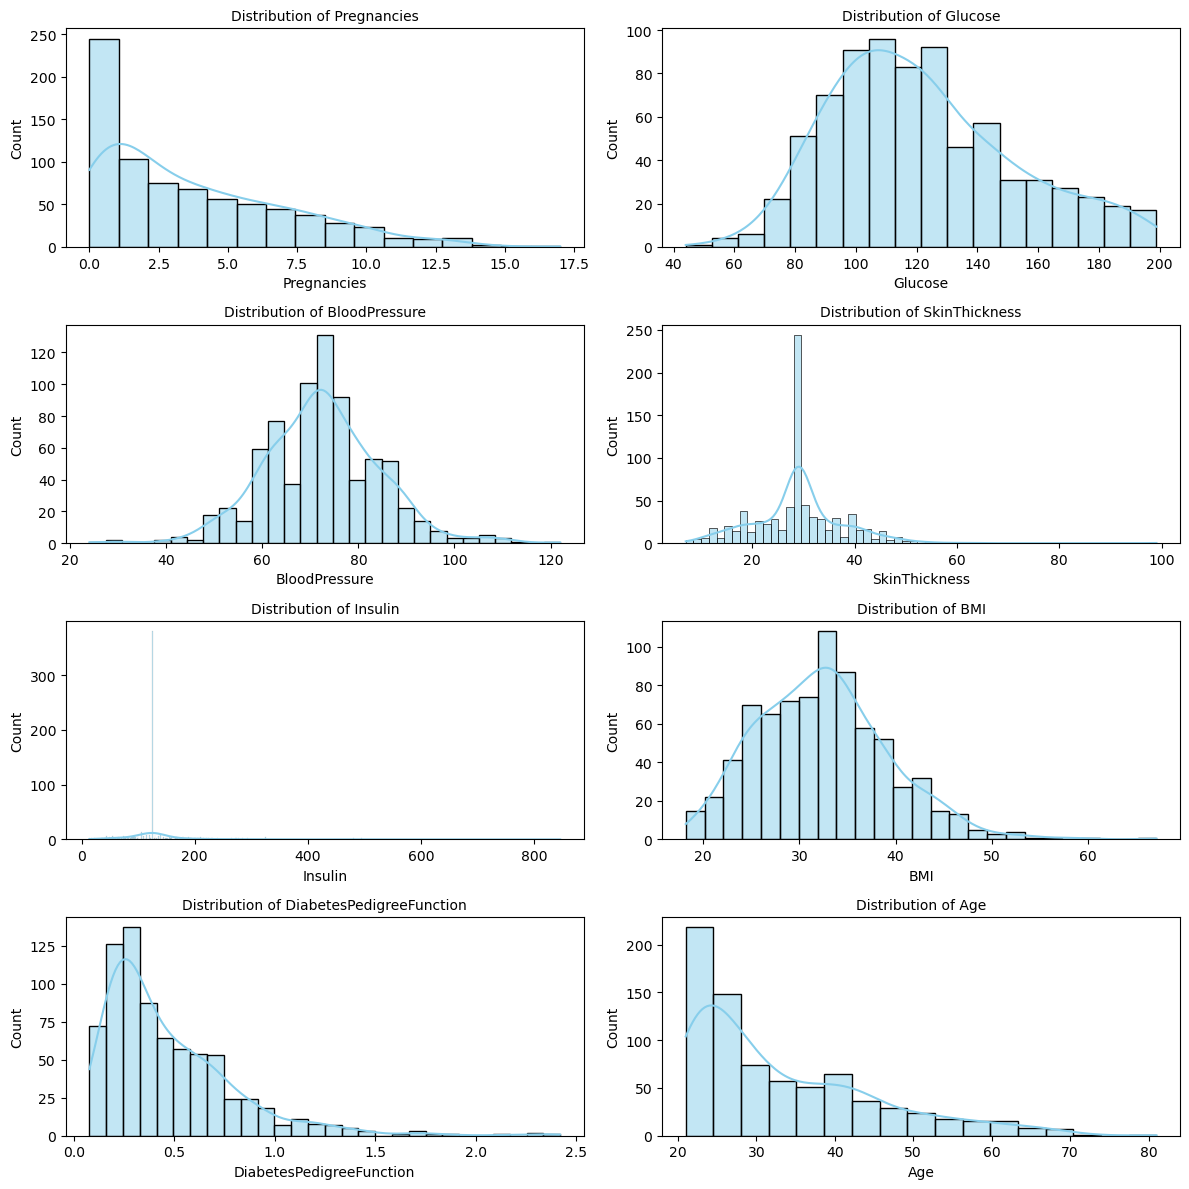

In [9]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
axes = axes.flatten()  


for i, feature in enumerate(features):
    sns.histplot(data=df, x=feature, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {feature}', fontsize=10)

plt.tight_layout()
plt.show()

### dealing with outliers

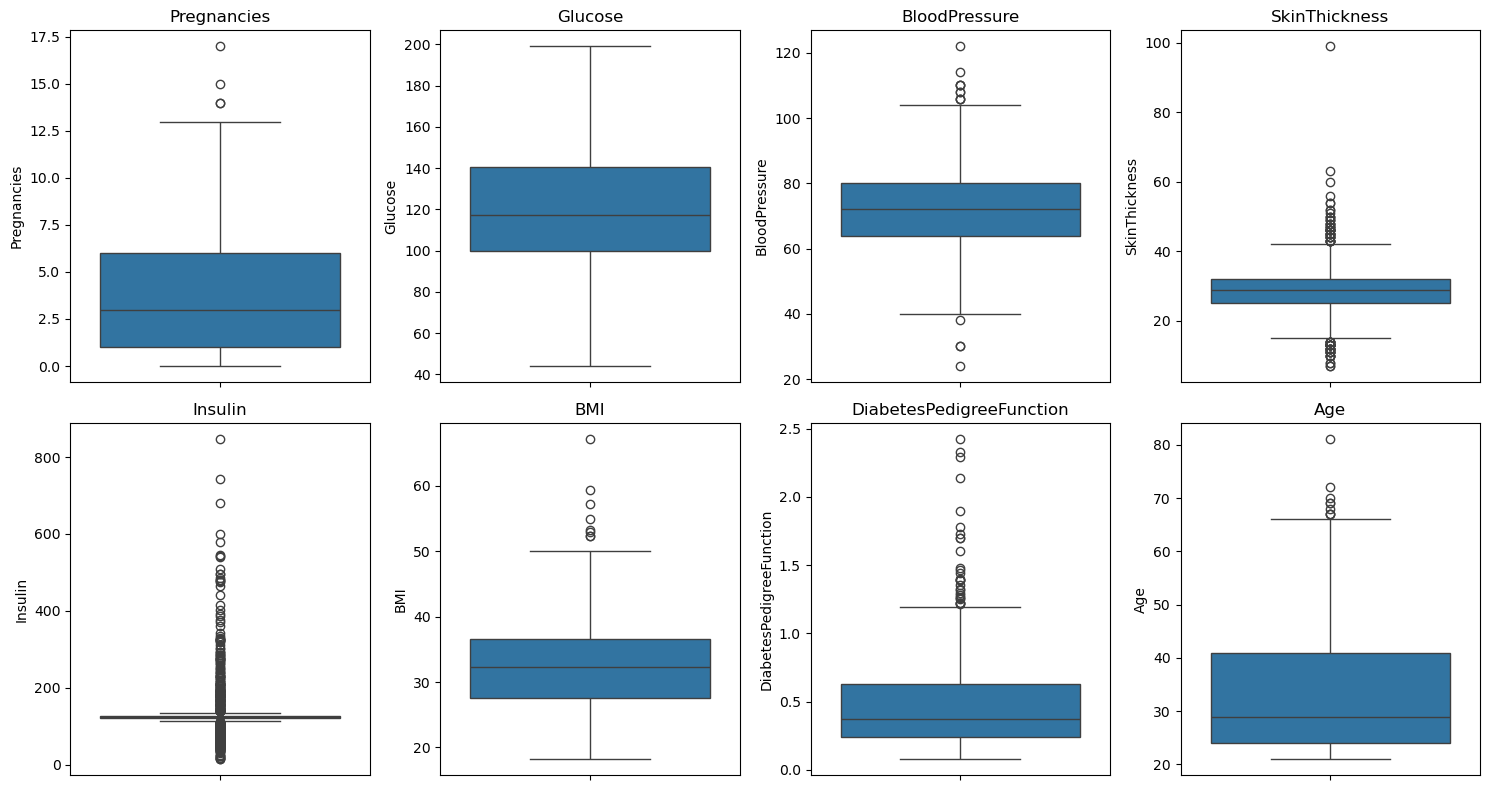

In [10]:
features = df.columns[:-1]

plt.figure(figsize=(15, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [11]:
# outliers detection with IQR method: 

def outlier_detector_IQR(df):
    outlier_indices = []

    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col]<lower_bound) | (df[col]>upper_bound)].index
        outlier_indices.extend(outliers)

    outlier_counts = pd.Series(outlier_indices).value_counts()
    return outlier_counts

In [12]:
outlier_counts = outlier_detector_IQR(x)
print(outlier_counts)

445    4
662    3
125    3
39     3
177    3
      ..
232    1
231    1
229    1
225    1
684    1
Name: count, Length: 392, dtype: int64


In [13]:
#type(outlier_counts)
rows_to_drop = outlier_counts[outlier_counts >= 2].index
print(f"number of row where there are ourliers in 2+ features: {len(rows_to_drop)}")

number of row where there are ourliers in 2+ features: 96


as we can see in the boxplots, there are several features in which we should deal with outliers: Insulin, SkinThickness,  
DiabetesPedigreeFunction. Let's not drop but winsorize those columns

In [14]:
def winsorize(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr

    df[col] = np.clip(df[col], lower, upper)

# applying the function above: 
for i in ['Insulin', 'SkinThickness', 'DiabetesPedigreeFunction']:
    winsorize(df, i)

now let's see the boxplots after treating outliers

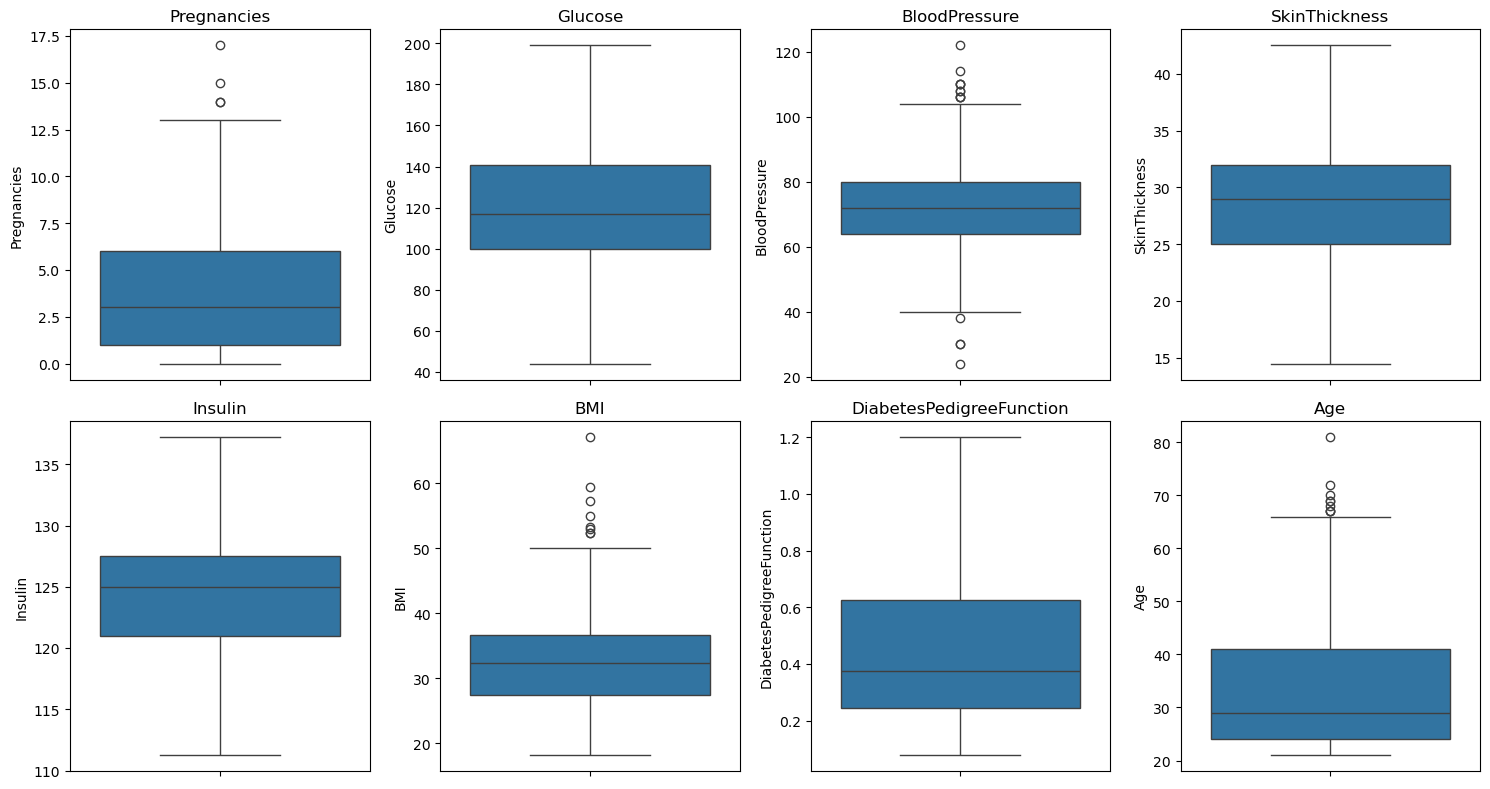

In [15]:
features = df.columns[:-1]

plt.figure(figsize=(15, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

### Standardization

In [34]:
# spliting into features and target
x = df.drop('Outcome', axis=1)
y = df["Outcome"]

# scaling 
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [35]:
# spliting for training and test sets 
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=69, stratify=y)

In [39]:
type(x_train)

numpy.ndarray

# KNN algorithm from scratch

In [19]:
# Euclidean distance
def euclidean_distance(pt1, pt2):
    dist = np.sqrt(np.sum((pt1-pt2)**2))
    return dist

In [20]:
pt1 = np.array([3,4])
pt2 = np.array([5,9])

euclidean_distance(pt1, pt2)

5.385164807134504

In [44]:
# knn algorithm
def knn(x_train, x_test, y_train, y_test, k_val):
    y_hat = []
    for test_pt in x_test:
        distances = []
        for i in range(len(x_train)):
            distances.append(euclidean_distance(x_train[i], test_pt))

        distance_df = pd.DataFrame(data=distances, columns=["distance"], index=pd.Series(y_train).index)
        k_neighbours_list = distance_df.sort_values(by=["distance"], axis=0)[:k_val]
        labels = y_train.loc[k_neighbours_list.index]
        voting = mode(labels, keepdims=True).mode[0]

        y_hat.append(voting)
    return y_hat

In [60]:
classification = knn(x_train, x_test, y_train, y_test, 15)

### testing accuracy 

In [61]:
acc = accuracy_score(classification, y_test)
print(f"prediction accuracy of my scratch algorithm is {round(acc*100,2)}%")

prediction accuracy of my scratch algorithm is 81.82%


# sklearn KNN 

In [62]:
from sklearn.neighbors import KNeighborsClassifier

In [63]:
knn_model = KNeighborsClassifier(n_neighbors=15)

In [64]:
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [65]:
y_pred = knn_model.predict(x_test)

In [67]:
acc_sklearn = accuracy_score(y_test, y_pred)
print(f"prediction accuracy of sklearn algorithm is {round(acc_sklearn*100,2)}%")

prediction accuracy of sklearn algorithm is 81.82%


# Performance evaluation

### confusion matrices

In [68]:
from sklearn.metrics import confusion_matrix

In [69]:
cm_scratch = confusion_matrix(y_test, classification)
cm_sklearn = confusion_matrix(y_test, y_pred)

In [71]:
print("Scratch KNN Confusion Matrix:\n", cm_scratch)
print("Sklearn KNN Confusion Matrix:\n", cm_sklearn)

Scratch KNN Confusion Matrix:
 [[93  7]
 [21 33]]
Sklearn KNN Confusion Matrix:
 [[93  7]
 [21 33]]


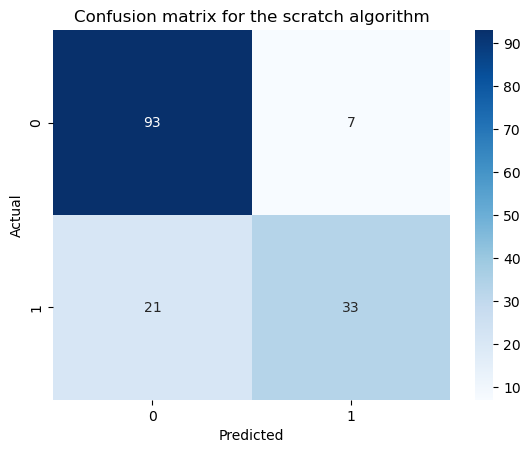

In [72]:
# let's visualize these confusion matrices with heatmap
sns.heatmap(cm_scratch, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix for the scratch algorithm")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

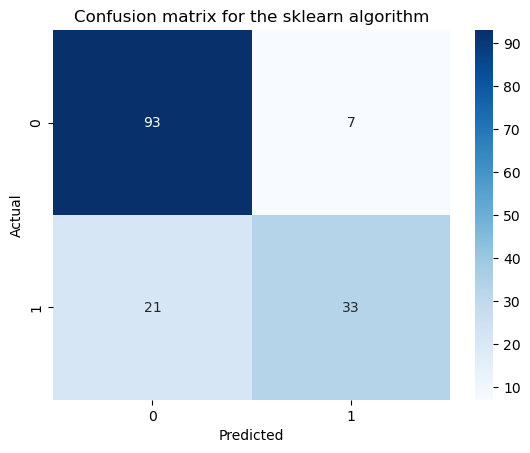

In [74]:
# heatmap for sklearn knn algorithm
sns.heatmap(cm_sklearn, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix for the sklearn algorithm")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### classification report

In [75]:
from sklearn.metrics import classification_report

In [76]:
print("Scratch KNN Classification Report:\n", classification_report(y_test, classification))
print("Sklearn KNN Classification Report:\n", classification_report(y_test, y_pred))

Scratch KNN Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87       100
           1       0.82      0.61      0.70        54

    accuracy                           0.82       154
   macro avg       0.82      0.77      0.79       154
weighted avg       0.82      0.82      0.81       154

Sklearn KNN Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87       100
           1       0.82      0.61      0.70        54

    accuracy                           0.82       154
   macro avg       0.82      0.77      0.79       154
weighted avg       0.82      0.82      0.81       154

